In [1]:
# for plotting, run: pip install pandas matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

e:\omar_envs\omarAmazonLarge\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

In [3]:
df = pd.read_excel('df_2023.xlsx')
df, df.columns

(          tarih      saat   yıl  ay  hafta  teklif_edilen_satış_miktarı_mwh  \
 0    2023-01-01  00:00:00  2023   1      6                          24715.9   
 1    2023-01-01  01:00:00  2023   1      6                          25001.4   
 2    2023-01-01  02:00:00  2023   1      6                          25543.4   
 3    2023-01-01  03:00:00  2023   1      6                          25595.6   
 4    2023-01-01  04:00:00  2023   1      6                          25430.5   
 ...         ...       ...   ...  ..    ...                              ...   
 9499 2024-01-31  19:00:00  2024   1      2                          43979.2   
 9500 2024-01-31  20:00:00  2024   1      2                          43444.3   
 9501 2024-01-31  21:00:00  2024   1      2                          43235.1   
 9502 2024-01-31  22:00:00  2024   1      2                          38718.1   
 9503 2024-01-31  23:00:00  2024   1      2                          38190.6   
 
       eşleşen_satış_miktarı_mwh  pozi

In [4]:
df = df[['tarih', 'saat', 'ptf_tl_mwh']]
df

,tarih,saat,ptf_tl_mwh
0,2023-01-01,00:00:00,3999.99
1,2023-01-01,01:00:00,3500.00
2,2023-01-01,02:00:00,2700.01
3,2023-01-01,03:00:00,3500.00
4,2023-01-01,04:00:00,3999.98
...,...,...,...
9499,2024-01-31,19:00:00,2560.00
9500,2024-01-31,20:00:00,2350.00
9501,2024-01-31,21:00:00,2245.00
9502,2024-01-31,22:00:00,2253.64


In [5]:
train = df[df['tarih'] < '2024-01-01'].reset_index(drop = True)
test = df[df['tarih'] >= '2024-01-01'].reset_index(drop = True)

In [6]:
context = torch.tensor(train["ptf_tl_mwh"])
prediction_length = 24

In [7]:
forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=100,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
    limit_prediction_length=False
)

In [8]:
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

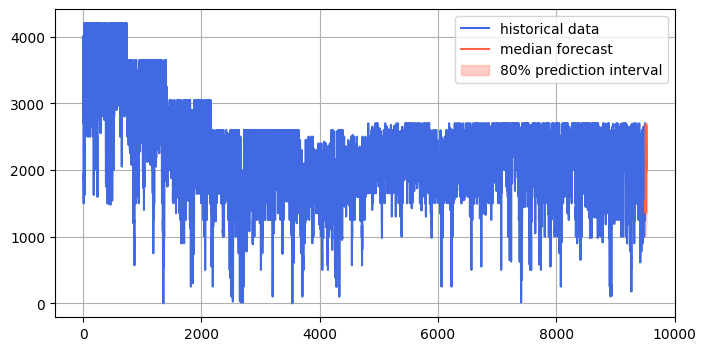

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(df["ptf_tl_mwh"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [10]:
final = pd.DataFrame()
final['real'] = test['ptf_tl_mwh'][:24]
final['pred'] = forecast[0][0].numpy()
final

,real,pred
0,1299.98,1518.424453
1,1299.98,1457.074011
2,1248.54,1365.048347
3,1299.98,1365.048347
4,1200.00,1012.282304
5,1200.00,1365.048347
6,1248.54,2009.227995
7,1299.99,2177.942710
8,1299.99,2714.760080
9,1399.98,2714.760080


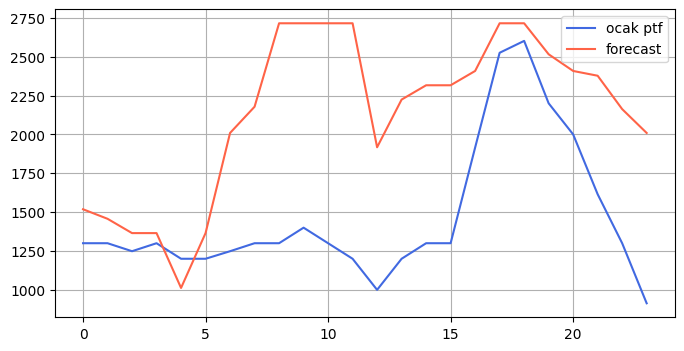

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(final["real"], color="royalblue", label="ocak ptf")
plt.plot(final['pred'], color="tomato", label="forecast")
# plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [12]:
(1 / (final['pred'] / final['real']))

0     0.856137
1     0.892185
2     0.914649
3     0.952333
4     1.185440
5     0.879090
6     0.621403
7     0.596889
8     0.478860
9     0.515692
10    0.478860
11    0.442028
12    0.521593
13    0.539574
14    0.561308
15    0.561308
16    0.795325
17    0.930101
18    0.958258
19    0.874627
20    0.830558
21    0.679333
22    0.601117
23    0.454722
dtype: float64